## Real or Not

Kaggle Challenge

## Imputs

In [86]:
# Imports
import pandas as pd

from sklearn.model_selection import train_test_split
import spacy
from spacy.tokenizer import Tokenizer

from collections import Counter
import squarify
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [2]:
# where am I
%pwd

'C:\\Users\\avery\\Lambda\\Unit4\\Sprint1\\Real'

In [6]:
# load in train / test
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [10]:
print(train.shape)
print(test.shape)
train.sample(2)

(7613, 5)
(3263, 4)


,id,keyword,location,text,target
1649,2382,collapsed,NaN,On the 2nd year the officer team running the c...,0
1025,1487,body%20bags,Wisconsin,@BoomerangTime @RSKarim1 @sopameer @wattashit3...,0


In [14]:
# train / validation split
train, val = train_test_split(train,test_size=.25)
print(train.shape)
print(val.shape)

(5709, 5)
(1904, 5)


## Clean Data ~ Tokenize text

In [23]:
nlp = spacy.load("en_core_web_lg")

tokenizer = Tokenizer(nlp.vocab)

In [33]:
# Wrangle Data

def wrangle_data(df):
    
    # tokenize data
    tokens = []
    STOP_WORDS = nlp.Defaults.stop_words.union([" ", "  ", "i'm", "it's", "\n", ])
    
    for doc in tokenizer.pipe(df["text"], batch_size=500):
        
        doc_tokens = []
        
        for token in doc:
            
            if (token.text.lower() not in STOP_WORDS) and (token.is_punct == False):
                doc_tokens.append(token.lemma_.lower())

        tokens.append(doc_tokens)

    df['tokens'] = tokens
    
        
    return df


In [34]:
wrangle_data(train)
wrangle_data(val)
wrangle_data(test)

print(train.shape)
print(val.shape)
print(test.shape)

(5709, 6)
(1904, 6)
(3263, 5)


In [35]:
train["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [36]:
train["tokens"][0]

['deeds', 'reason', '#earthquake', 'allah', 'forgive']

# EDA

In [37]:
word_count = Counter()
train["tokens"].apply(lambda x: word_count.update(x))

word_count.most_common(10)

[('like', 284),
 ('&amp;', 229),
 ('fire', 204),
 ('new', 165),
 ('bomb', 136),
 ("don't", 131),
 ('get', 130),
 ('kill', 130),
 ('people', 127),
 ('2', 124)]

In [39]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

    
# use count function on train    
wc = count(train['tokens'])
wc.head()  

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
1,like,270,284,1.0,0.005141,0.005141,0.047294
22,&amp;,207,229,2.0,0.004145,0.009286,0.036259
33,fire,185,204,3.0,0.003693,0.012979,0.032405
925,new,159,165,4.0,0.002987,0.015966,0.027851
1203,bomb,131,136,5.0,0.002462,0.018427,0.022946


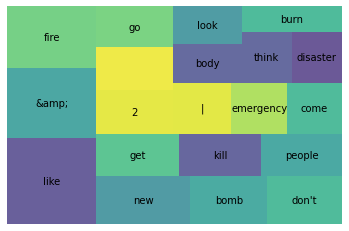

In [41]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Use Scikit-Learn's CountVectorizer to get word counts

In [77]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [ ]:
data = train['text']

# Count Vectorizer
# instantiate vectorizer object
vect = CountVectorizer(stop_words='english', 
                       tokenizer = tokenize)

# build vocab 
vect.fit(data)

# transform data/ store doc text matrix
dtm = vect.transform(data)

In [61]:
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

In [62]:
dtm.head()

,00,000,0000,007npen6lg,00cy9vxeff,00end,01,02,02elqlopfk,02pm,...,ûò,ûò800000,ûòthe,ûòåêcnbc,ûó,ûóher,ûókody,ûónegligence,ûótech,ûówe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# Get Word Counts
result = []
for col in dtm:
    x = sum(dtm[col])
    result.append(x)

data = zip(vect.get_feature_names(),result)
words = pd.DataFrame(data, columns=["words", "count"])

In [66]:
# top 10 used words
words["rank"] = words["count"].rank(method="first", ascending=False)
words[words["rank"] <= 10]

,words,count,rank
1563,amp,262,4.0
4917,don,146,8.0
7610,http,3260,1.0
7611,https,314,2.0
8620,just,239,6.0
9353,like,258,5.0
10769,new,174,7.0
10780,news,141,10.0
11735,people,144,9.0
17560,û_,265,3.0


## Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [73]:
# TF-IDF
data = train['text']

# instantiate
tfidf = TfidfVectorizer(stop_words='english')

#fit / transform
dtm = tfidf.fit_transform(data)

In [74]:
dtm.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [75]:
dtm.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
dtm.head()

,00,000,0000,007npen6lg,00cy9vxeff,00end,01,02,02elqlopfk,02pm,...,ûò,ûò800000,ûòthe,ûòåêcnbc,ûó,ûóher,ûókody,ûónegligence,ûótech,ûówe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create a NearestNeighbor Mode

In [81]:
# Nearest Neighbors
# instantiate / grab 5 neighbors
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')

# fit
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [82]:
nn.kneighbors([dtm.iloc[0].values])

(array([[0.        , 1.18204235, 1.18352774, 1.20667781, 1.24369552]]),
 array([[   0, 2469, 3237, 2320, 1369]], dtype=int64))

In [83]:
data[0][:200]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [84]:
data[2469][:200]

'PHOTOS: Green Line derailment near Cottage Grove and Garfield: http://t.co/4d9Cd4mnVh http://t.co/UNhqCQ6Bex'

In [85]:
data[3237][:200]

'Just saw a car on the I-77 Fully engulfed in flames hahah'

## Classification Pipeline

In [87]:
# Pipline Components

vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2))

rfc = RandomForestClassifier()

In [88]:
# Define the Pipeline
pipe = Pipeline([
    ("vect", vect),
    ("rfc", rfc)])

# fit
pipe.fit(train["text"], train["target"])

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [89]:
# preict
pipe.predict(['good love peace money', 'drugs fires loss hahah'])

array([0, 1], dtype=int64)

In [102]:
# Predictions on test sample
ypred = pipe.predict(val['text'])

In [104]:
pipe.score(val['text'],val['target'])

0.7956932773109243

In [105]:
# Predictions on test sample
pred = pipe.predict(test['text'])

In [106]:
submission = pd.DataFrame({'id': test['id'], 'target':pred})
submission['target'] = submission['target'].astype('int64')

In [107]:
# Make Sure the Category is an Integer
submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [108]:
subNumber = 0
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./submission{subNumber}.csv', index=False)
subNumber += 1

## Try different visualizations for words and frequencies

In [ ]:
dir(pipe)

## Fit a Gensim LDA topic model

named entity recognition  
generator object  
classification model  
topic model